# Boeing Retrieval-Augmented Generation 
### A conversational bot that allows you to speak directly with your documents.

In [1]:
!pip install langchain
!pip install openai
!pip install langchain-openai
!pip install ipywidgets
!pip install pymupdf
!pip install whisper
!pip install -U docarray
!pip install langchain-pinecone
!pip install scikit-learn

Before beginning, please add your own OpenAI & Pinecone API keys to the environment variables.

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

## Setting up the model

In [3]:
from langchain_openai.chat_models import ChatOpenAI

model = ChatOpenAI(openai_api_key = OPENAI_API_KEY, model="gpt-3.5-turbo")

Test to see if the chatgpt api works:

In [4]:
model.invoke("Who is the current president of the United States?")

AIMessage(content='Joe Biden', response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 17, 'total_tokens': 19}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'stop', 'logprobs': None}, id='run-106129e4-3950-422d-b1b0-42d3eec19d0c-0')

# Parsing

Parse out all additional information so that we only get our desired response:

In [5]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

chain = model | parser
chain.invoke("Who is the current president of the United States?")

'The current president of the United States is Joe Biden.'

## Prompt Building

We want to provide our model with some context and the question itself. Prompt templates allow us to define and reuse prompts.

In [6]:
from langchain.prompts import ChatPromptTemplate

template = """
Answer the question based on the context below. If you can't answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt.format(context = "Joe Biden is the 46th President of the United States", question="What number president is Joe Biden?")

'Human: \nAnswer the question based on the context below. If you can\'t answer the question, reply "I don\'t know".\n\nContext: Joe Biden is the 46th President of the United States\n\nQuestion: What number president is Joe Biden?\n'

Now we can chain the prompt with the model and the output parser.

In [7]:
chain = prompt | model | parser
chain.invoke({
    "context": "Joe Biden is the 46th President of the United States",
    "question": "What number president is Joe Biden?"
})

'Joe Biden is the 46th President of the United States.'

## Creating data to serve as context for our RAG application

In this section we will take Boeing documents in pdf format, and convert them into .txt files.

In [11]:

import ipywidgets as widgets
from IPython.display import display
import fitz  # PyMuPDF

global extracted_text
extracted_text = ""  # This will hold the text extracted from the PDF

import re

def pdf_to_text_and_save(pdf_path):
    global extracted_text  # Declare the use of the global variable
    
    with fitz.open(pdf_path) as doc:
        text = ""
        for page in doc:
            page_text = page.get_text()
            # Sanitize the text to remove non-ASCII characters
            page_text = re.sub(r'[^\x00-\x7F]+', ' ', page_text)
            text += page_text
    
    extracted_text = text  # Update the global variable with extracted text
    
    # Fixed filename for the output text file
    txt_file_path = "converted.txt"
    
    # Save the sanitized text to 'converted.txt'
    with open(txt_file_path, "w", encoding="utf-8") as txt_file:
        txt_file.write(text)
    
    return txt_file_path


def select_file_and_notify_conversion():
    uploader = widgets.FileUpload(
        accept='.pdf',
        multiple=False
    )
    display(uploader)
    
    def on_upload_change(change):
        if not uploader.value:
            return
        
        uploaded_files = uploader.value
        
        # Check if uploaded_files is a tuple
        if isinstance(uploaded_files, tuple):
            # In case of tuple, get the first element
            uploaded_files = uploaded_files[0]
        
        print("uploaded_files type:", type(uploaded_files))
        print("uploaded_files content:", uploaded_files)
        
        # Access the uploaded file information
        file_name = uploaded_files['name']
        content = uploaded_files['content']
        
        # Save the uploaded PDF to a temporary file
        with open(file_name, 'wb') as f:
            f.write(content)
        
        # Convert the PDF to text, update the global variable, and save the text to 'converted.txt'
        txt_file_path = pdf_to_text_and_save(file_name)
        print(f"Converted {file_name} to text and saved to {txt_file_path}.")
        
        # Clear the uploader for future uploads
        if isinstance(uploader.value, tuple):
            uploader.value[0].clear()
        else:
            uploader.value.clear()
        uploader._counter = 0
    
    uploader.observe(on_upload_change, names='value')

# Display the file picker
select_file_and_notify_conversion()


FileUpload(value=(), accept='.pdf', description='Upload')

uploaded_files type: <class 'traitlets.utils.bunch.Bunch'>
uploaded_files content: {'name': '6c05fe5e978d2e2e229955e3a35e9717.pdf', 'type': 'application/pdf', 'size': 1165372, 'content': <memory at 0x00000247F1E8E680>, 'last_modified': datetime.datetime(2024, 4, 22, 23, 42, 16, 929000, tzinfo=datetime.timezone.utc)}
Converted 6c05fe5e978d2e2e229955e3a35e9717.pdf to text and saved to converted.txt.


Let's read the .txt file and display the first few characters to ensure it was converted correctly.

In [12]:
print(extracted_text[:100])  # Print the first 100 characters of the extracted text


 
 
 
DELTA VIRTUAL AIRLINES 
 
 
 
BOEING 777-200ER 
AIRCRAFT OPERATING MANUAL 
THIRD EDITION 
 
NO


## Using the entire document as context

If we try to invoke the chain using the entire document, the model will return an error because the context is too long (i.e too many tokens).

Large Language Models support limited context sizes. In the case of chatgpt, the maximum content lengfth is 16385 tokens.

In [13]:
try:
    chain.invoke({
        "context": extracted_text,
        "question": "Summarize this document."
    })
except Exception as e:
    print(e)

## Splitting the document as context

Since some documents in their entirety can't be used as context for the model, we have to split the document into smaller chunks.

For now, let's load the document in memory:

In [14]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("converted.txt")
text_documents = loader.load()

Now let's split the document into small chunks. Down below is an example of how it works:

In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=20)
text_splitter.split_documents(text_documents)[:10]

[Document(page_content='DELTA VIRTUAL AIRLINES \n \n \n \nBOEING 777-200ER \nAIRCRAFT OPERATING MANUAL \nTHIRD EDITION', metadata={'source': 'converted.txt'}),
 Document(page_content='THIRD EDITION \n \nNOVEMBER 2005 \n \nTABLE OF CONTENTS', metadata={'source': 'converted.txt'}),
 Document(page_content='Table of Contents', metadata={'source': 'converted.txt'}),
 Document(page_content='...................................................................................................', metadata={'source': 'converted.txt'}),
 Document(page_content='.......................2', metadata={'source': 'converted.txt'}),
 Document(page_content='Aircraft History and Background', metadata={'source': 'converted.txt'}),
 Document(page_content='and Background .................................................................................1', metadata={'source': 'converted.txt'}),
 Document(page_content='Engine', metadata={'source': 'converted.txt'}),
 Document(page_content='Types....................

For our specific needs, let's use 1000 chars instead:

In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(text_documents)

## Finding Relevant Chunks

Given a particular question, we need to find the relevant chunks from the document to send to the model. Here is where the idea of 'embeddings' comes into play.

An embedding is a mathematical representation of the semantic meaning of a word, sentence, or document.

In [16]:
from langchain_openai.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
embedded_query = embeddings.embed_query("Who is the President of the United States?")

print(f"Embedding length: {len(embedded_query)}")
print(embedded_query[:10])

Embedding length: 1536
[-0.0062157722273827, -0.02248361370923725, -0.0028908804996813256, -0.020213399412536824, -0.00791539730392648, -0.004713425024089968, 0.002781618897596253, 0.002767961051816464, -0.02833518059633637, 0.00444634079744115]


To further illustrate how embedding work, let's generate the embedding for two different sentences:

In [19]:
sentence1 = embeddings.embed_query("Who is the President of the United States?")
sentence2 = embeddings.embed_query("Trump was the 45th President of the United States.")

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

query_sentence1_similarity = cosine_similarity([embedded_query], [sentence1])[0][0]
query_sentence2_similarity = cosine_similarity([embedded_query], [sentence2])[0][0]

query_sentence1_similarity, query_sentence2_similarity

(0.9999999999999996, 0.8539730811931538)

As you can see, the similarity between both sentences are relatively close. OpenAI is a powerful tool for this application because it's built in embeddings gives our RAG a powerful basis in terms of creating and understanding context.

(0.9999999999999993, 0.8552301924902097)

## Setting up a Vector Store

We need an efficient way to store document chunks, their embeddings, and perform similarity searchers at scale. To do this, we'll use a vector store.

A vector store is a database of embeddings that specializes in fast similarity searches.

In [11]:
from langchain_community.vectorstores import DocArrayInMemorySearch

vectorstore1 = DocArrayInMemorySearch.from_texts(
    [
        "Which individual currently holds the presidency in the U.S.?",
        "Franklin D. Roosevelt served as the 32nd President during a critical period in American history.",
        "Who was inaugurated as the U.S. President following the 2020 election?",
        "Air Force One is the official air transport for the President of the United States.",
        "Theodore Roosevelt became the first sitting president to fly in an airplane in 1910.",
        "How often does the President use Air Force One for international trips?",
        "The call sign 'Air Force One' is used whenever the President is aboard the aircraft."
    ],
    embedding=embeddings,
)

retriever = vectorstore1.as_retriever()

NameError: name 'embeddings' is not defined

We can now query the vector store to find the most similar embeddings to a given query:

In [19]:
vectorstore1.similarity_search_with_score(query="Which individual currently holds the presidency in the U.S.?", k=3)

[(Document(page_content='Which individual currently holds the presidency in the U.S.?'),
  1.0),
 (Document(page_content='Who was inaugurated as the U.S. President following the 2020 election?'),
  0.8648888457895858),
 (Document(page_content='Franklin D. Roosevelt served as the 32nd President during a critical period in American history.'),
  0.8046005109773987)]

In [20]:
from langchain_openai.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

## Connecting Vector Store to the chain

We can now use our vector store to find most relevant chunks from our Boeing documents to send to the model.

But first, we need to configure a Retriever. The retriever will run a similarity search in the vector store and return the most similar documents back to the next step in the chain.

We can get a retriever directly from the vector store we just created:

In [21]:
retriever1 = vectorstore1.as_retriever()
retriever1.invoke("Who is the President of the United States?")

[Document(page_content='Which individual currently holds the presidency in the U.S.?'),
 Document(page_content='Who was inaugurated as the U.S. President following the 2020 election?'),
 Document(page_content='Air Force One is the official air transport for the President of the United States.'),
 Document(page_content='How often does the President use Air Force One for international trips?')]

Our prompt expects two parameters, "context" and "question". We can use the retriever to find the chunks we'll use as the context to answer the question.

We can create a map with the two inputs by using the RunnableParralel and RunnablePassthrough classes. 

This will allow us to pass the context and question to the prompt as a map with the keys "context" and "question".

In [22]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

setup = RunnableParallel(context=retriever, question=RunnablePassthrough())
setup.invoke("Air Force One is typically flown by who?")

{'context': [Document(page_content='Air Force One is the official air transport for the President of the United States.'),
  Document(page_content="The call sign 'Air Force One' is used whenever the President is aboard the aircraft."),
  Document(page_content='How often does the President use Air Force One for international trips?'),
  Document(page_content='Which individual currently holds the presidency in the U.S.?')],
 'question': 'Air Force One is typically flown by who?'}

Now we can add this setup map to the chain and run it:

In [23]:
chain = setup | prompt | model | parser
chain.invoke("If Joe Biden needed to travel to another country, which mode of transportion will he use?")

'Air Force One'

## Loading the Boeing Docmuent into the vector store

We initialized the vector store with a few random strings. Let's create a new vector store using the chunks from our Boeing document that we previously uploaded:

In [24]:
vectorstore2 = DocArrayInMemorySearch.from_documents(documents, embeddings)

Let's set up a new chain using the correct vector store. This time we are using a different equivalent syntax to specify the RunnableParallel portion of the the chain:

In [25]:
setup2 = RunnableParallel(
    context = vectorstore2.as_retriever(), question=RunnablePassthrough()
)

chain = setup2 | prompt | model | parser

chain.invoke("What is this document about? Can you give me a brief summary of it?")

'This document seems to be an aircraft operating manual for the Boeing 777-200ER, specifically for Delta Virtual Airlines. It includes information on aircraft specifications, design weights, power plants, field lengths, range, speeds, altitudes, fuel consumption, recommended equipment, and standard operating procedures for various stages of flight such as pre-flight, takeoff, climb, cruise, descent, approach, landing, and securing the aircraft.'

In [26]:
chain = (
    {"context": vectorstore2.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)

chain.invoke("Tell me about the engines in this document.")


"The document mentions three types of engines: Rolls-Royce Trent 800, General Electric GE90, and Pratt & Whitney PW4090. It provides details about each engine's specifications, technologies, and capabilities."

## Setting up Pinecone

So far, we've used an in-memory vector store. In practice, we need a vector store that can handle large amounts of data and perform similarity searches at scale. For this project, we'll use Pinecone.

First create a Pinecone account, set up an index(1536 dimensions since we are using OpenAI), get an API key, and set it as the environment variable PINE_CONE_API_KEY in the .env file.

Then we can load the documents into Pinecone:

In [27]:
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore

index_name = "boeing-nlp-ai"

pinecone = PineconeVectorStore.from_documents(
    documents, embeddings, index_name=index_name
)


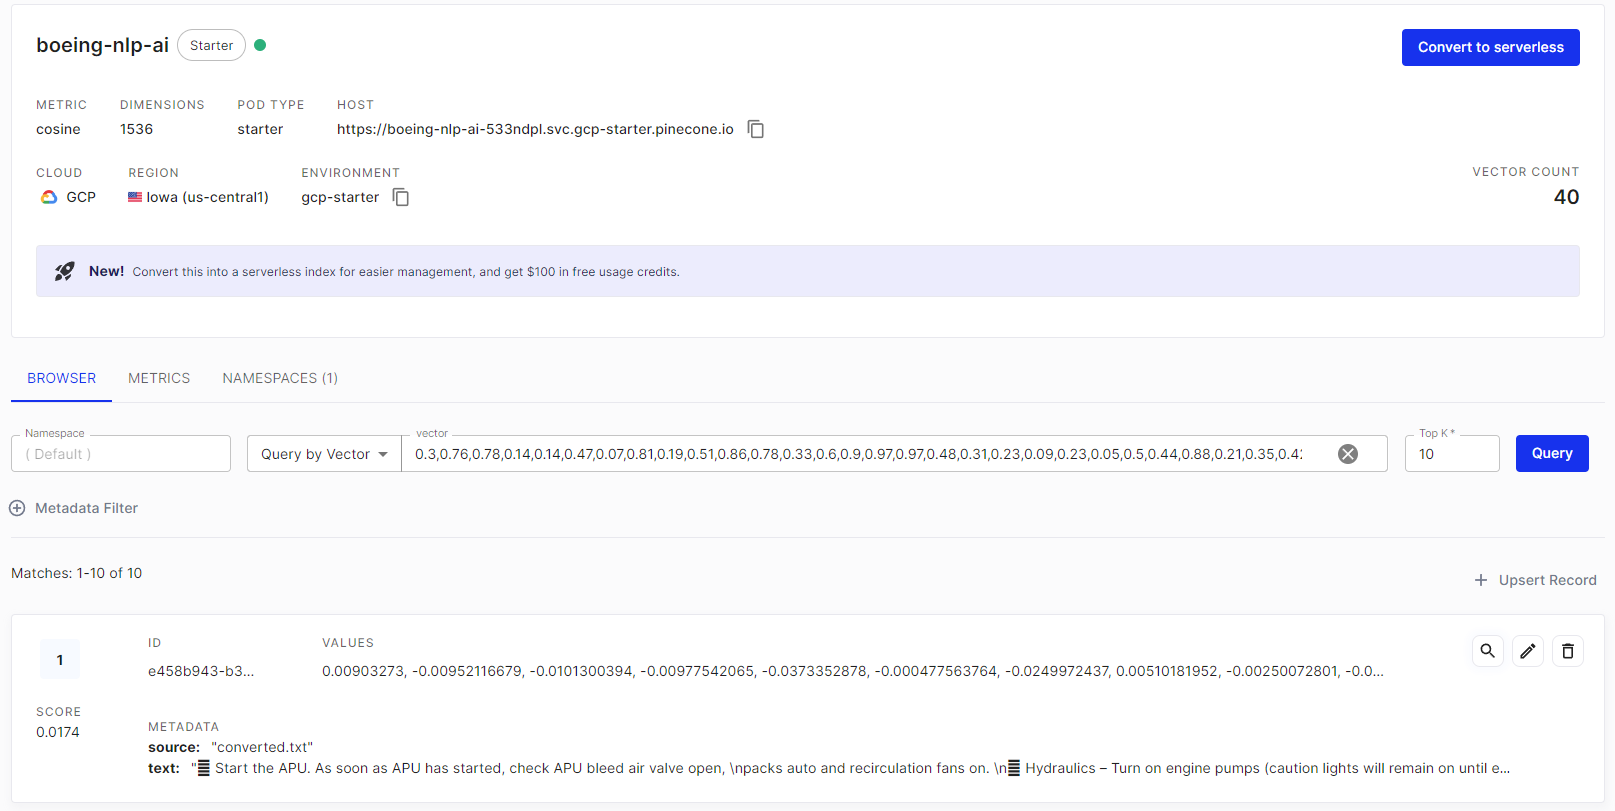